In [27]:
from typing import List
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from anbe_tool.plotting import method_pal

In [28]:
plt.style.use('default')
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42 

In [29]:
def method_label_map(label):
    label = label.replace("MAGeCK-RRA_bot_", "MAGeCK-RRA_")
    if "MAGeCK-MLE_sort" in label:
        label = label.replace("MAGeCK-MLE_sort_var_", "MAGeCK-MLE_")
        
        label = label.replace("EM", "+edit rate")
        label = label.replace("f", " (fitted)")
    return label

In [30]:
bean_method_label_map = {
    "MultiMixtureNormal": "BEAN-Reporter",
    "MultiMixtureNormal+Acc": "BEAN",
    "Normal_allEdited": "BEAN-Uniform: All",
    "Normal_behive": "BEAN-Uniform: BE-Hive",
    "MAGeCK-MLE_sort_var_behive":"MAGeCK-MLE: BE-Hive",
    "MAGeCK-MLE_sort_var_allEdited":"MAGeCK-MLE: All",
    "MAGeCK-MLE_sort_behive":"MAGeCK-MLE(const): BE-Hive",
    "MAGeCK-MLE_sort_allEdited":"MAGeCK-MLE(const): All",
    "MAGeCK-RRA_bot_behive":"MAGeCK-RRA: BE-Hive",
    "MAGeCK-RRA_bot_allEdited":"MAGeCK-RRA: All",
    "CB2_behive":"CB2: BE-Hive",
    "CB2_allEdited":"CB2: All",
    "CRISPhieRmix_behive":"CRISPhieRmix: BE-Hive",
    "CRISPhieRmix_allEdited":"CRISPhieRmix: all",
}
def method_label_map(label):
    if label in bean_method_label_map.keys():
        return bean_method_label_map[label]
    label = label.replace("MAGeCK-RRA_bot_", "MAGeCK-RRA_")
    if "MAGeCK-MLE_sort" in label:
        label = label.replace("MAGeCK-MLE_sort_var_", "MAGeCK-MLE:").replace("MAGeCK-MLE_sort_", "MAGeCK-MLE(sort) ")
        label = label.replace("EM", "+edit rate")
        label = label.replace("f", " (fitted)")
    return label

pal = sns.color_palette("colorblind")
pal_dark = sns.color_palette("dark")

method_pal = {
    "BEAN": pal[-1],
    "BEAN-Reporter": pal[0],
    "BEAN-Uniform: BE-Hive": pal_dark[2],
    "BEAN-Uniform: All": pal[2],
    "CB2: BE-Hive": pal_dark[4],
    "CB2: All": pal[4],
    "MAGeCK-RRA: BE-Hive": pal_dark[-2],
    "MAGeCK-RRA: All": pal[-2],
    "MAGeCK-MLE: BE-Hive": pal_dark[1],
    "MAGeCK-MLE: All": pal[1],
    "CRISPhieRmix: BE-Hive": pal_dark[5],
    "CRISPhieRmix: All": pal[5],
    "EC-LFC":pal[-3],
    "LFC": pal_dark[-3],
}
method_pal_ext = {
    "BEAN": pal[-1],
    "BEAN-Reporter": pal[0],
    "BEAN-Uniform: BE-Hive": pal_dark[2],
    "BEAN-Uniform: All": pal[2],
    "CB2: BE-Hive": pal_dark[4],
    "CB2: All": pal[4],
    "MAGeCK-RRA: BE-Hive": pal_dark[-2],
    "MAGeCK-RRA: All": pal[-2],
    "MAGeCK-MLE: BE-Hive": pal_dark[1],
    "MAGeCK-MLE: All": pal[1],
    "MAGeCK-MLE(const): BE-Hive": pal_dark[3],
    "MAGeCK-MLE(const): all": pal[3],
    "CRISPhieRmix: BE-Hive": pal_dark[5],
    "CRISPhieRmix: All": pal[5],
    "EC-LFC":pal[-3],
    "LFC": pal_dark[-3],
    
}

def sort_df(df, key):
    df['method_cat'] = df.method.astype("category")
    df.method_cat = df.method_cat.cat.set_categories(key)
    return df.sort_values('method_cat')

# 2-replicate subsamples


In [31]:
import os 
import re

comb_dirs=[]
reg_compile = re.compile(r"bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete_rep\d*_rep\d*")
for dirname in os.listdir("../../results/model_runs/"):
    if reg_compile.match(dirname):
        comb_dirs.append(dirname)

comb_dirs

['bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete_rep7_rep8',
 'bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete_rep6_rep7',
 'bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete_rep5_rep8',
 'bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete_rep6_rep8',
 'bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete_rep5_rep6',
 'bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete_rep5_rep7']

# PR curve


## Full dataset



In [32]:
scores_tbl = pd.read_csv("../../results/model_runs/bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete/all_scores_negctrl.csv")

<ipython-input-32-fac3bf552c3d>:1: DtypeWarning: Columns (4,6,8,9,10,11,28,31,33,35,36,37,38,75,96,104,143,151,183,184,189,191,192) have mixed types. Specify dtype option on import or set low_memory=False.
  scores_tbl = pd.read_csv("../../results/model_runs/bean_count_LDLRCDS_annotated_spacer0.1_0.3_complete/all_scores_negctrl.csv")


In [33]:
def draw_prc(scores: pd.DataFrame, col_labels, method_label_map, ax, inverse_score= True, title="", alpha = 1, annot_name="clinvar_annot_2", posctrl_labels=["Pathogenic/Likely_Pathogenic"], negctrl_label="Benign/Likely_Benign", draw_legend=True, draw_baseline=True, print_auprc=False):
    auprcs = {}
    scores = scores.loc[(scores[annot_name].isin(posctrl_labels + [negctrl_label])),:]
    pos_ctrl = scores[annot_name].isin(posctrl_labels)
    neg_ctrl = scores[annot_name] == negctrl_label
    pr_list = []
    for col in col_labels:
        score = scores[col]
        if inverse_score: 
            score = -score
            score[np.isnan(score)] = -100
        else:
            score[np.isnan(score)] = -1
        precision, recall, thresholds = precision_recall_curve(pos_ctrl, score)
        auprc = average_precision_score(pos_ctrl, score)
        pr_list.append(pd.DataFrame({"method":col, "precision":precision, "recall":recall}))
        if draw_legend:
            if print_auprc: label = f"{method_label_map[col]}({auprc:.3f})"
            else: label = method_label_map[col]
        else: label="_"
        ax.plot(recall, precision, color=method_pal[method_label_map[col]], label=label, alpha=alpha, linewidth=1)#linestyle=('--' if "behive" in col else '-')
        auprcs[method_label_map[col]] = auprc
    if draw_baseline:
        no_skill = pos_ctrl.sum() / len(pos_ctrl)
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'Random({no_skill:.3f})', color='grey')
        auprcs['baseline'] = no_skill
        pr_list.append(pd.DataFrame({"method":["random"], "precision":[no_skill], "recall":[np.nan]}))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fontsize='small',)
    ax.set_title(title)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')  
    return auprcs, pd.concat(pr_list, axis=0)

In [61]:
def draw_prcs(prefix: str, file_labels: List[str], method_label_map,ax, inverse_score= True, title="", alpha = 0.05, **kwargs):
    score_tbls = []
    auprc_list = []
    for file_label in file_labels:
        score_tbl = pd.read_csv(prefix.format(file_label), low_memory=False)
        score_tbl['nLFC'] = -score_tbl["pos|lfc_rra_bot_allEdited"]
        score_tbl['ecLFC'] = score_tbl.nLFC/(score_tbl["effective_edit_rate_MultiMixtureNormal"]+1e-3)
        score_tbls.append(score_tbl)
        res, _ = draw_prc(score_tbl, method_label_map.keys(), method_label_map, ax, alpha = alpha, draw_legend=False, **kwargs)
        auprc_list.append(res)
    all_scores = pd.concat(score_tbls)
    res, pr_df = draw_prc(all_scores, method_label_map.keys(), method_label_map, ax, title=title, **kwargs)
    res = pd.DataFrame(auprc_list, index=file_labels)
    return res, pr_df

In [35]:
def get_f1(scores: pd.DataFrame, col_labels, method_label_map, annot_name="clinvar_annot_2", posctrl_labels=["Pathogenic/Likely_Pathogenic"], negctrl_label="Benign/Likely_Benign"):
    f1s = {}
    scores = scores.loc[(scores[annot_name].isin(posctrl_labels + [negctrl_label])),:]
    pos_ctrl = scores[annot_name].isin(posctrl_labels)
    neg_ctrl = scores[annot_name] == negctrl_label
    for col in col_labels:
        score = scores[col]
        f1s[method_label_map[col]] = f1_score(pos_ctrl, score < 0.05)
    return f1s

def get_f1s(prefix: str, file_labels: List[str], method_label_map, annot_name="clinvar_annot_2", posctrl_labels=["Pathogenic/Likely_Pathogenic"], negctrl_label="Benign/Likely_Benign"):
    score_tbls = []
    auprc_list = []
    for file_label in file_labels:
        score_tbl = pd.read_csv(prefix.format(file_label))
        score_tbl['nLFC'] = -score_tbl["pos|lfc_rra_bot_allEdited"]
        score_tbls.append(score_tbl)
        res = get_f1(score_tbl, method_label_map.keys(), method_label_map, annot_name, posctrl_labels, negctrl_label)
        auprc_list.append(res)
    res = pd.DataFrame(auprc_list, index=file_labels)
    return res

In [45]:
method_label_map_fdr = {
    "mu_z_MultiMixtureNormal+Acc": "BEAN",
    "mu_z_MultiMixtureNormal": "BEAN-Reporter",
    "mu_z_Normal_allEdited": "BEAN-Uniform: All",
    "mu_z_Normal_behive": "BEAN-Uniform: BE-Hive",
    'fdr_pb_CB2_allEdited': "CB2: All",
    'fdr_pb_CB2_behive': "CB2: BE-Hive",
    "pos|fdr_rra_bot_allEdited":"MAGeCK-RRA: All",
    "pos|fdr_rra_bot_behive":"MAGeCK-RRA: BE-Hive",
    "sort_num|fdr_sort_var_allEdited":"MAGeCK-MLE: All",
    "sort_num|fdr_sort_var_behive":"MAGeCK-MLE: BE-Hive",
    'FDR_CRISPhieRmix_allEdited': "CRISPhieRmix: All",
    'FDR_CRISPhieRmix_behive': "CRISPhieRmix: BE-Hive",
    "ecLFC":"EC-LFC",
    "nLFC":"LFC",
}
label_map = method_label_map_fdr.copy()
label_map["random"] = "random"

In [37]:
method_label_map_fdr_main = {
    "mu_z_MultiMixtureNormal+Acc": "BEAN",
    "mu_z_MultiMixtureNormal": "BEAN-Reporter",
    "mu_z_Normal_allEdited": "BEAN-Uniform: All",
    "pos|fdr_rra_bot_allEdited":"MAGeCK-RRA: All",
    "sort_num|fdr_sort_var_allEdited":"MAGeCK-MLE: All",
    'fdr_pb_CB2_allEdited': "CB2: All",
    'FDR_CRISPhieRmix_allEdited': "CRISPhieRmix: All",
}
method_label_map_fdr_behive = {
    "mu_z_MultiMixtureNormal+Acc": "BEAN",
    "mu_z_MultiMixtureNormal": "BEAN reporter",
    "mu_z_Normal_behive": "BEAN BE-Hive",
    "pos|fdr_rra_bot_behive":"MAGeCK-RRA: BE-Hive",
    "sort_num|fdr_sort_var_behive":"MAGeCK-MLE: BE-Hive",
    'fdr_pb_CB2_behive': "CB2: BE-Hive",
    'FDR_CRISPhieRmix_BE-Hive': "CRISPhieRmix: BE-Hive",
}

In [38]:
scores_tbl['nLFC'] = -scores_tbl["pos|lfc_rra_bot_allEdited"]
scores_tbl['ecLFC'] = scores_tbl['nLFC']/scores_tbl["effective_edit_rate_MultiMixtureNormal"]

In [39]:
prefix="../../results/model_runs/{}/all_scores_negctrl.csv"

[None, None]

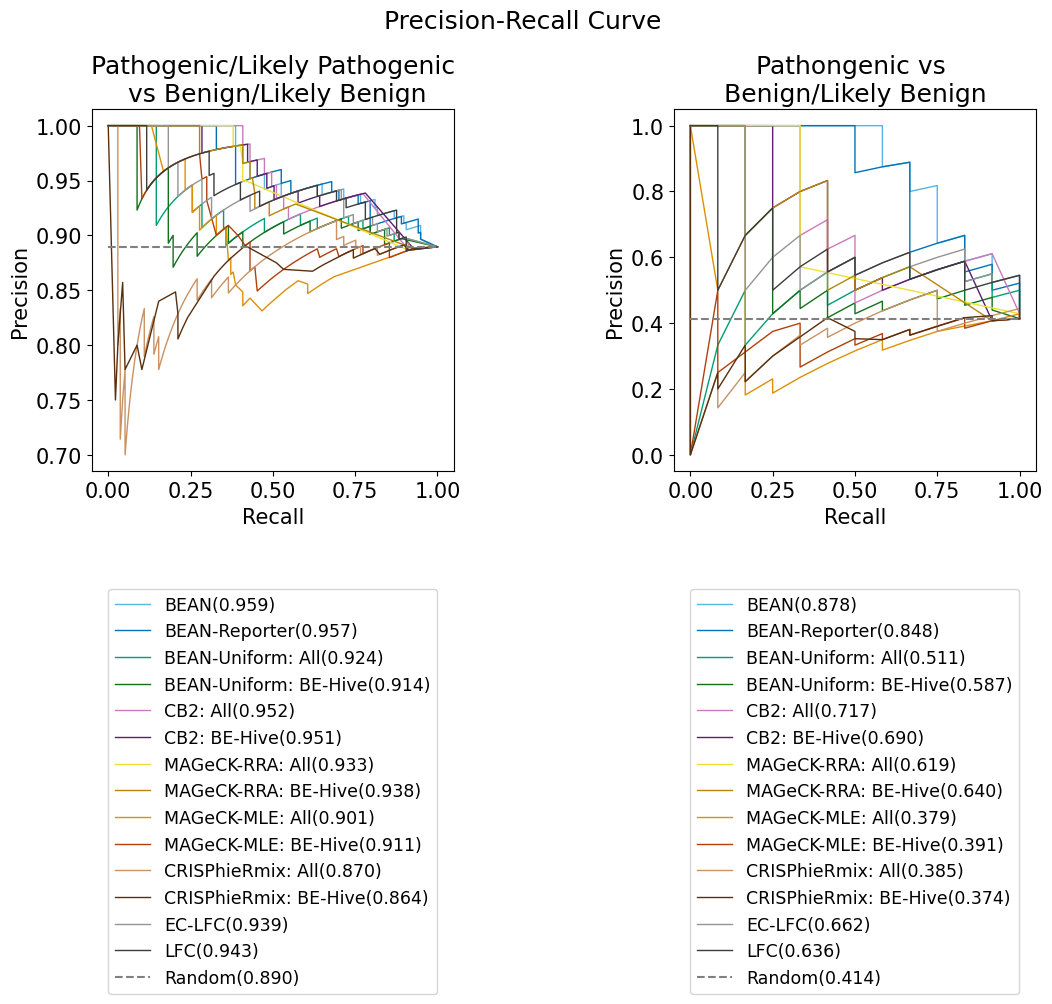

In [51]:
plt.style.use('jr')
fig, ax = plt.subplots(1, 2, figsize=(12,12))
auprcs_plp, pr_df_plp = draw_prc(scores_tbl, method_label_map_fdr.keys(), method_label_map_fdr, ax[0], title="Pathogenic/Likely Pathogenic\n vs Benign/Likely Benign", print_auprc=True)
auprcs_p, pr_df_p = draw_prc(scores_tbl, method_label_map_fdr.keys(), method_label_map_fdr, ax[1], title="Pathongenic vs \nBenign/Likely Benign", annot_name='clinvar_annot_3', posctrl_labels=["Pathogenic"], print_auprc=True)
plt.suptitle("Precision-Recall Curve")
plt.tight_layout()
plt.setp(ax, box_aspect=1)
#fig.savefig('f_PRC_full.pdf',  bbox_inches='tight')

In [52]:
pr_df_plp["classification"] = "P/LP vs B/LB"
pr_df_p["classification"] = "P vs B/LB"
pr_df = pd.concat([pr_df_plp, pr_df_p], axis=0)
pr_df['method'] = pr_df['method'].map(label_map)
pr_df

,method,precision,recall,classification
0,BEAN,0.889610,1.000000,P/LP vs B/LB
1,BEAN,0.896552,0.948905,P/LP vs B/LB
2,BEAN,0.902778,0.948905,P/LP vs B/LB
3,BEAN,0.909091,0.948905,P/LP vs B/LB
4,BEAN,0.908451,0.941606,P/LP vs B/LB
...,...,...,...,...
26,LFC,0.666667,0.166667,P vs B/LB
27,LFC,0.500000,0.083333,P vs B/LB
28,LFC,1.000000,0.083333,P vs B/LB
29,LFC,1.000000,0.000000,P vs B/LB


In [53]:
pr_df.to_csv("E7bc.csv")

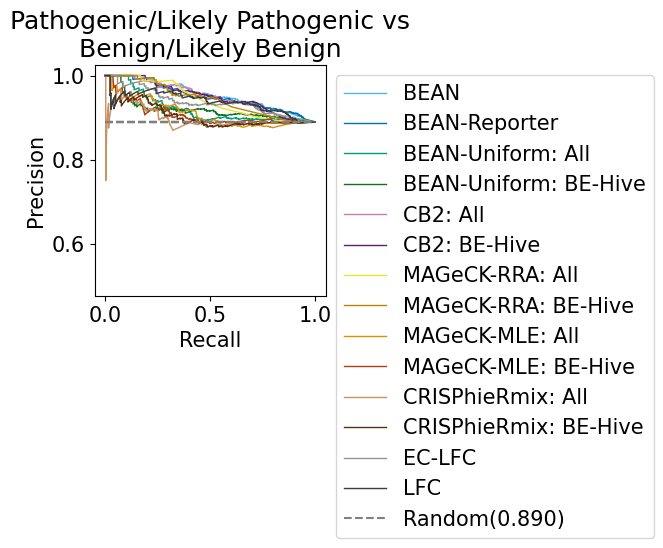

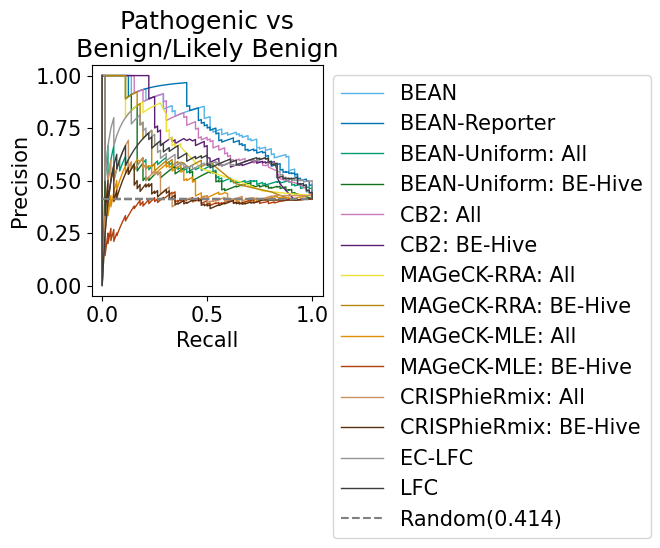

In [62]:
fig, ax = plt.subplots(figsize=(4,3))
auprcs_subsamples_plp, pr_df_plp = draw_prcs(prefix, comb_dirs, method_label_map_fdr, ax, title="Pathogenic/Likely Pathogenic vs\nBenign/Likely Benign", alpha=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[-(len(method_label_map_fdr.keys())+1):],
         labels=labels[-(len(method_label_map_fdr.keys())+1):])

ax.set_box_aspect(1)
fig.savefig('f_PRC_2reps_plpbl.pdf',  bbox_inches='tight')
#fig.savefig('f_PRC_2reps_plpbl.svg',  bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
auprcs_subsamples_p, pr_df_p = draw_prcs(prefix, comb_dirs, method_label_map_fdr, ax, title="Pathogenic vs\nBenign/Likely Benign", annot_name='clinvar_annot_3', posctrl_labels=["Pathogenic"], alpha = 0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[-(len(method_label_map_fdr.keys())+1):],
         labels=labels[-(len(method_label_map_fdr.keys())+1):])
#ax.set_ylim((0.6, 1.02))
ax.set_box_aspect(1)
#fig.savefig('f_PRC_2reps_pbl.pdf',  bbox_inches='tight')

In [63]:
pr_df_plp["classification"] = "P/LP vs B/LB"
pr_df_p["classification"] = "P vs B/LB"
pr_df = pd.concat([pr_df_plp, pr_df_p], axis=0)
pr_df['method'] = pr_df['method'].map(label_map)
pr_df

,method,precision,recall,classification
0,BEAN,0.889610,1.000000,P/LP vs B/LB
1,BEAN,0.896552,0.948905,P/LP vs B/LB
2,BEAN,0.896433,0.947689,P/LP vs B/LB
3,BEAN,0.896313,0.946472,P/LP vs B/LB
4,BEAN,0.896194,0.945255,P/LP vs B/LB
...,...,...,...,...
166,LFC,0.000000,0.000000,P vs B/LB
167,LFC,0.000000,0.000000,P vs B/LB
168,LFC,0.000000,0.000000,P vs B/LB
169,LFC,1.000000,0.000000,P vs B/LB


In [64]:
pr_df.to_csv("E7de.csv")

In [16]:
auprcs_plp = pd.DataFrame({"method":auprcs_plp.keys(), "AUPRC":auprcs_plp.values()})
auprcs_p = pd.DataFrame({"method":auprcs_p.keys(), "AUPRC":auprcs_p.values()})

In [17]:
auprcs_subsamples_plp = auprcs_subsamples_plp.melt(var_name='method', value_name='AUPRC')
auprcs_subsamples_p = auprcs_subsamples_p.melt(var_name='method', value_name='AUPRC')

In [18]:
# save data table
auprcs_subsamples_plp['group'] = 'replicate subsamples'
auprcs_subsamples_plp['positive_controls'] = 'P/LP'
auprcs_subsamples_p['group'] = 'replicate subsamples'
auprcs_subsamples_p['positive_controls'] = 'P'
auprcs_plp['group'] = 'all replicates'
auprcs_plp['positive_controls'] = 'P/LP'
auprcs_p['group'] = 'all replicates'
auprcs_p['positive_controls'] = 'P'
pd.concat([auprcs_subsamples_plp, auprcs_subsamples_p, auprcs_plp, auprcs_p]).to_csv("Figure5_AUPRC_data.csv")

In [19]:
#https://stackoverflow.com/questions/61647192/boxplot-and-data-points-side-by-side-in-one-plot
def move_scatter(ax):
    path_collections = [child for child in ax.get_children() 
                    if isinstance(child,matplotlib.collections.PathCollection)] 

    for path_collection in path_collections: 
        x,y = np.array(path_collection.get_offsets()).T 
        if len(x) == 0: continue
        xnew = x -0.5
        offsets = list(zip(xnew,y)) 
        path_collection.set_offsets(offsets)

In [20]:
auprcs_p

,method,AUPRC,group,positive_controls
0,BEAN,0.877525,all replicates,P
1,BEAN-Reporter,0.847842,all replicates,P
2,BEAN-Uniform: All,0.510674,all replicates,P
3,BEAN-Uniform: BE-Hive,0.586737,all replicates,P
4,CB2: All,0.717059,all replicates,P
5,CB2: BE-Hive,0.689755,all replicates,P
6,MAGeCK-RRA: All,0.619048,all replicates,P
7,MAGeCK-RRA: BE-Hive,0.639558,all replicates,P
8,MAGeCK-MLE: All,0.378542,all replicates,P
9,MAGeCK-MLE: BE-Hive,0.391166,all replicates,P


<ipython-input-26-6c5a37e2c422>:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(auprcs_subsamples_p.loc[auprcs_subsamples_p.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", edgecolor="white", linewidth=1, palette = method_pal_ext, ax = ax, orient='h')


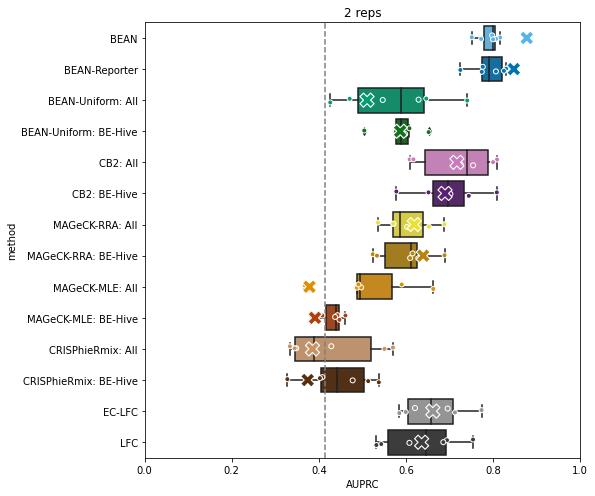

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(auprcs_subsamples_p.loc[auprcs_subsamples_p.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", palette = method_pal_ext, ax = ax, orient='h')
# sns.stripplot(auprcs_subsamples_p.loc[auprcs_subsamples_p.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", edgecolor="white", linewidth=1, palette = method_pal_ext, ax = ax, orient='h')
ax.axvline(auprcs_p.loc[auprcs_p.method == 'baseline', "AUPRC"].item(), linestyle = '--', color = 'grey')
sns.scatterplot(auprcs_p.loc[auprcs_p.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", hue='method', palette = method_pal_ext, ax = ax, s = 200, marker='X',zorder=100)
ax.get_legend().remove()
ax.set_xlim((0,1))
ax.set_title("2 reps")
plt.setp(ax, box_aspect=1)
plt.tight_layout()
fig.savefig("AUPRC_horizontal_P_all_and_subsamples_single_v2.pdf", bbox_inches="tight")

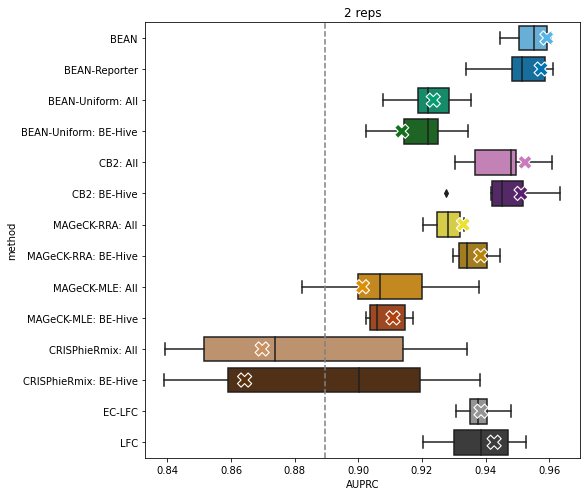

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(auprcs_subsamples_plp.loc[auprcs_subsamples_plp.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", palette = method_pal_ext, ax = ax, orient='h')
ax.axvline(auprcs_plp.loc[auprcs_plp.method == 'baseline', "AUPRC"].item(), linestyle = '--', color = 'grey')
sns.scatterplot(auprcs_plp.loc[auprcs_plp.method.isin(method_pal.keys())], y = 'method', x = "AUPRC", hue='method', palette = method_pal_ext, ax = ax, s = 200, marker='X',zorder=100)
ax.get_legend().remove()
ax.set_title("2 reps")
plt.setp(ax, box_aspect=1)
plt.tight_layout()
fig.savefig("AUPRC_horizontal_PLP_all_and_subsamples_single_v2.pdf", bbox_inches="tight")